In [1]:
try:
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

try:
    import pandas_ta as ta
except:
    !pip install pandas_ta
    import pandas_ta as ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=a5fcaead1de9b41c9ce752b16748dc0b92b3b8edad159158032d53f3286281f8
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

In [3]:
plt.rcParams["figure.figsize"] = (18, 4)
plt.rcParams["font.size"] = '18'

# Functions

In [ ]:
def plot_results(stock_obj, y_train_pred, y_val_pred, y_test_pred):
  plt.plot(stock_obj.dates, stock_obj.y, 'k', label='True')
  plt.plot(stock_obj.dates_train, y_train_pred, label='Predicted train')
  plt.plot(stock_obj.dates_val, y_val_pred, label='Predicted val')
  plt.plot(stock_obj.dates_test, y_test_pred, label='Predicted test')
  #plt.title(f'RMSE for validation set: {mean_squared_error(y_val, y_val_pred)}')
  m1 = np.sqrt(mean_squared_error(stock_obj.y_train, y_train_pred))
  m2 = np.sqrt(mean_squared_error(stock_obj.y_val, y_val_pred))
  m3 = np.sqrt(mean_squared_error(stock_obj.y_test, y_test_pred))
  plt.title(f'RMSE for train set: {m1}\nRMSE for val set: {m2}\nRMSE for test set: {m3}')
  plt.xlabel('Date')
  plt.ylabel('Close price')
  plt.legend()
  plt.show()

# Baseline - predict previous value

In [4]:
stock_names = ['ORAN', 'SBUX', 'ACP.WA', 'PFE']
full_names = ['ORANGE', 'STARBUCKS CORPORATION', 'ASSECO POLAND', 'PFIZER']

In [7]:
test=0.1
val=0.1
to_add = 0
def baseline_0(tick, name, test, val, to_add):
  data = yf.download(tickers=tick, start='2015-01-01', end='2023-01-01')
  data_1 = data.copy()
  data_1['Predict'] = data['Close'].shift(1)
  data_1.dropna(inplace=True)
  y = data_1['Close']
  y_pred = data_1['Predict']
  dates = data_1.index
  if tick == 'ACP.WA':
    to_add = 1
  for_test = int(len(y) * test) + to_add
  for_val = int(len(y) * val) + to_add
  to_train = len(y) - for_test - for_val
  y_train, y_val, y_test = y[:to_train], y[to_train:to_train+for_val], y[to_train+for_val:]
  y_train_pred, y_val_pred, y_test_pred = y_pred[:to_train], y_pred[to_train:to_train+for_val], y_pred[to_train+for_val:]
  dates_train, dates_val, dates_test = dates[:to_train], dates[to_train:to_train+for_val], dates[to_train+for_val:]
  plt.plot(dates, y, 'k', label='True')
  plt.plot(dates_train, y_train_pred, label='Predicted set 1')
  plt.plot(dates_val, y_val_pred, label='Predicted set 2')
  plt.plot(dates_test, y_test_pred, label='Predicted set 3')
  m1 = mean_squared_error(y_train, y_train_pred)
  m2 = mean_squared_error(y_val, y_val_pred)
  m3 = mean_squared_error(y_test, y_test_pred)
  print(f'MSE: {m1:.4f},  {m2:.4f},  {m3:.4f}')
  m1 = mean_absolute_percentage_error(y_train, y_train_pred)
  m2 = mean_absolute_percentage_error(y_val, y_val_pred)
  m3 = mean_absolute_percentage_error(y_test, y_test_pred)
  print(f'MAPE: {m1:.4f},  {m2:.4f},  {m3:.4f}')
  print(len(y_train), len(y_val), len(y_test))
  plt.title(f'{name} closing price - true and predicted, top - whole dataset, bottom - testing set')
  #plt.xlabel('Date')
  plt.ylabel('Close price')
  plt.legend()
  plt.show()
  plt.figure(figsize=(12, 5))
  plt.plot(dates_test, y_test, '-o', color='k', label='True', markersize=4)
  plt.plot(dates_test, y_test_pred, '-o', color='tab:green', label='Predicted', markersize=4)
  plt.title(f'{name} closing price - Baseline 1')
  plt.xlabel('Date')
  plt.ylabel('Close price')
  plt.legend()
  plt.show()

[*********************100%%**********************]  1 of 1 completed


MSE: 0.0505,  0.0175,  0.0183
MAPE: 0.0104,  0.0085,  0.0099
1611 201 201


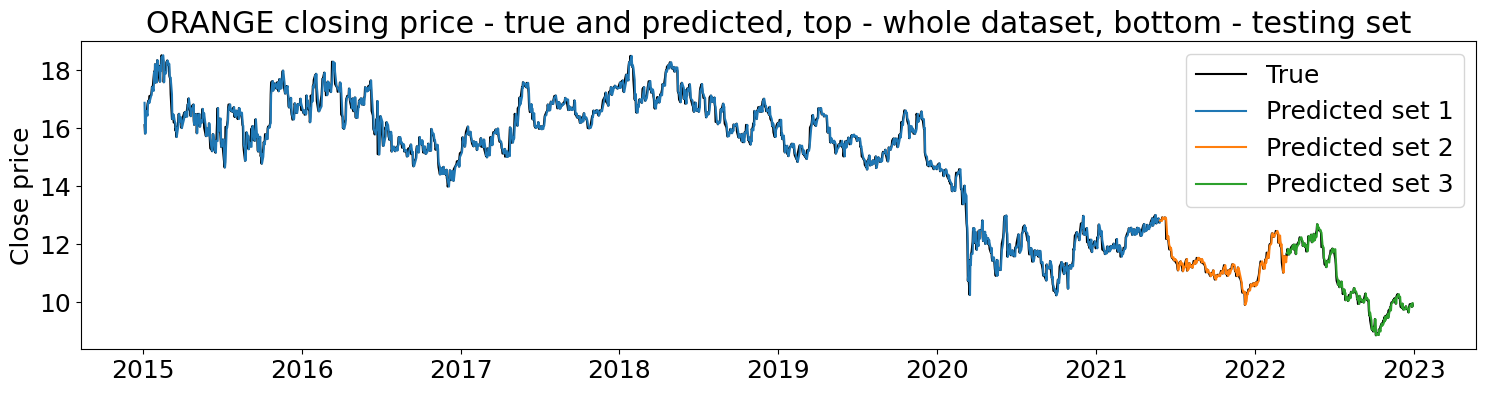

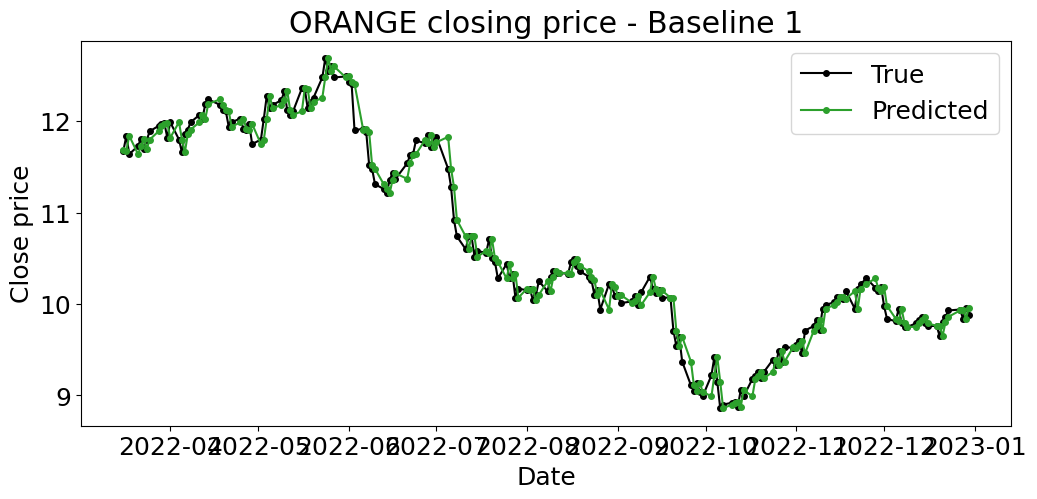

[*********************100%%**********************]  1 of 1 completed


MSE: 1.3542,  2.7918,  3.4944
MAPE: 0.0107,  0.0114,  0.0163
1611 201 201


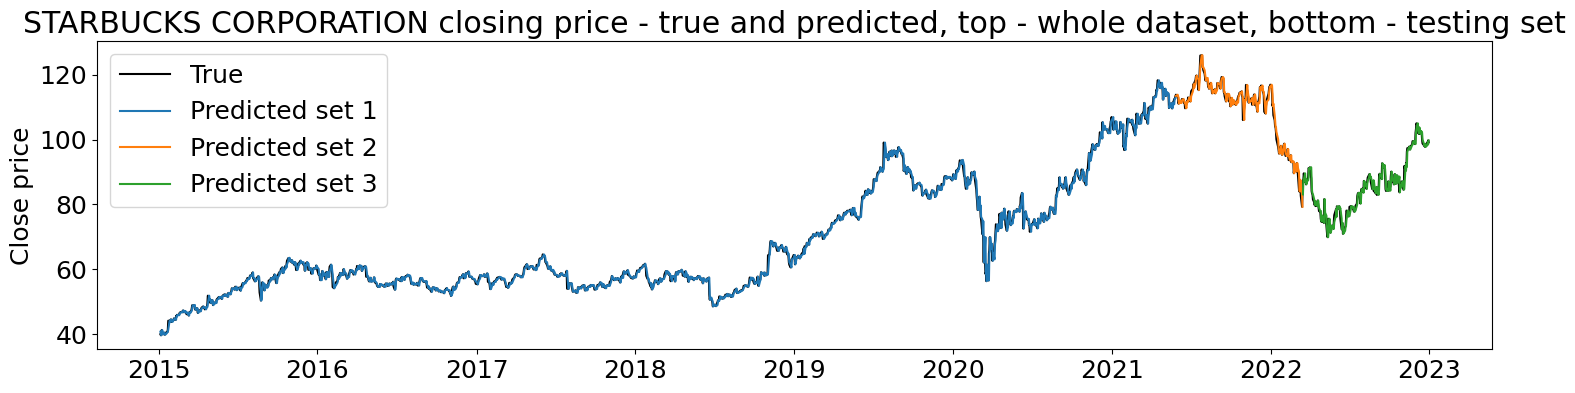

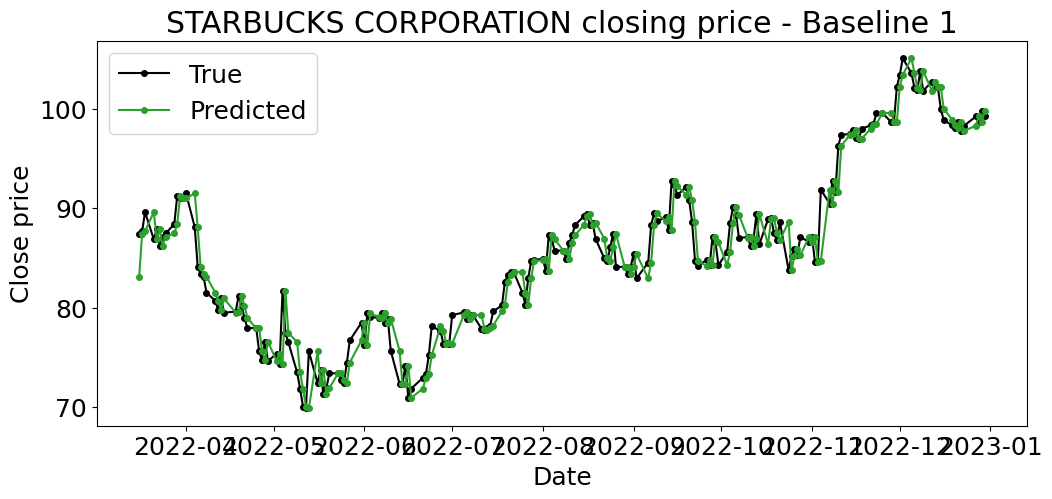

[*********************100%%**********************]  1 of 1 completed


MSE: 0.9268,  2.4055,  2.1755
MAPE: 0.0123,  0.0134,  0.0151
1639 205 205


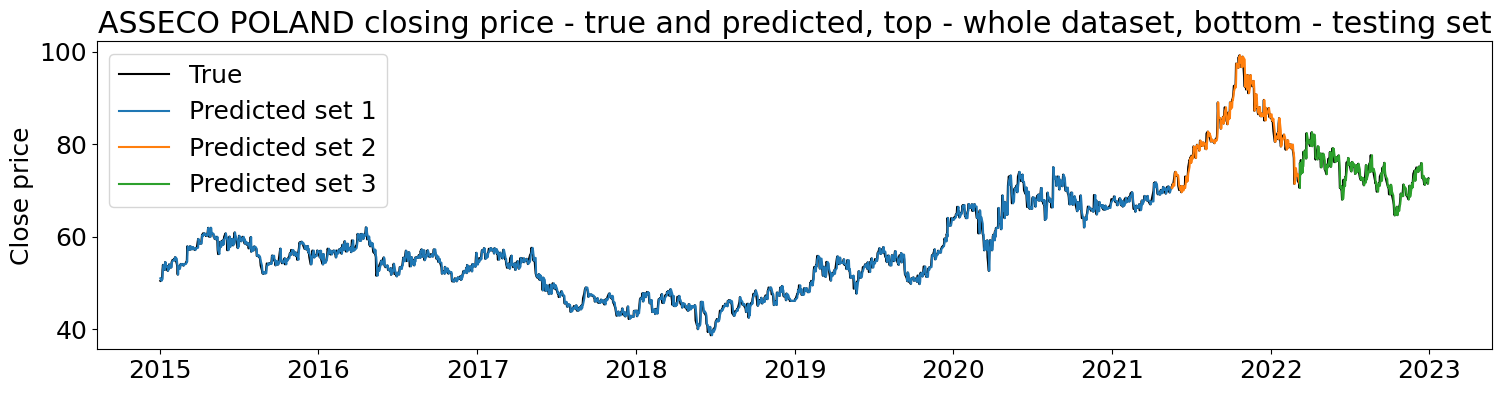

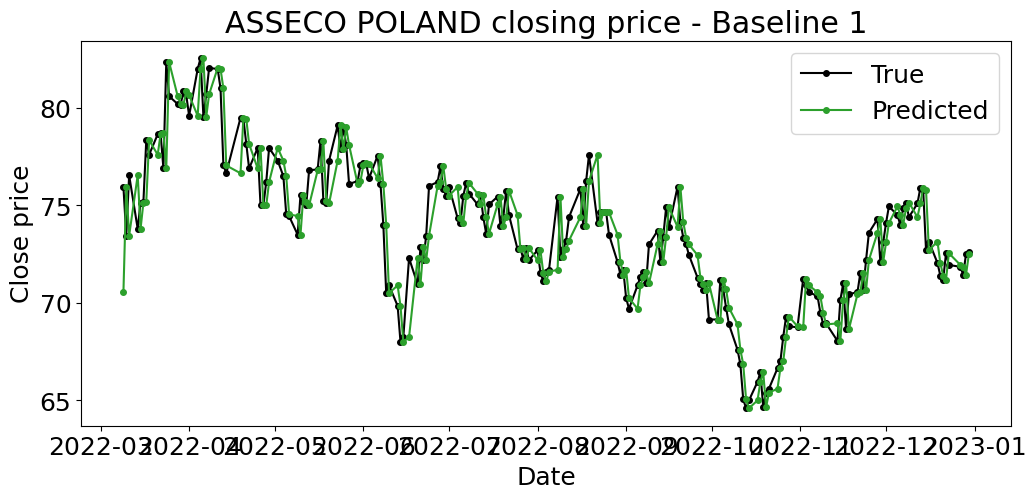

[*********************100%%**********************]  1 of 1 completed


MSE: 0.2187,  0.9507,  0.6462
MAPE: 0.0093,  0.0141,  0.0129
1611 201 201


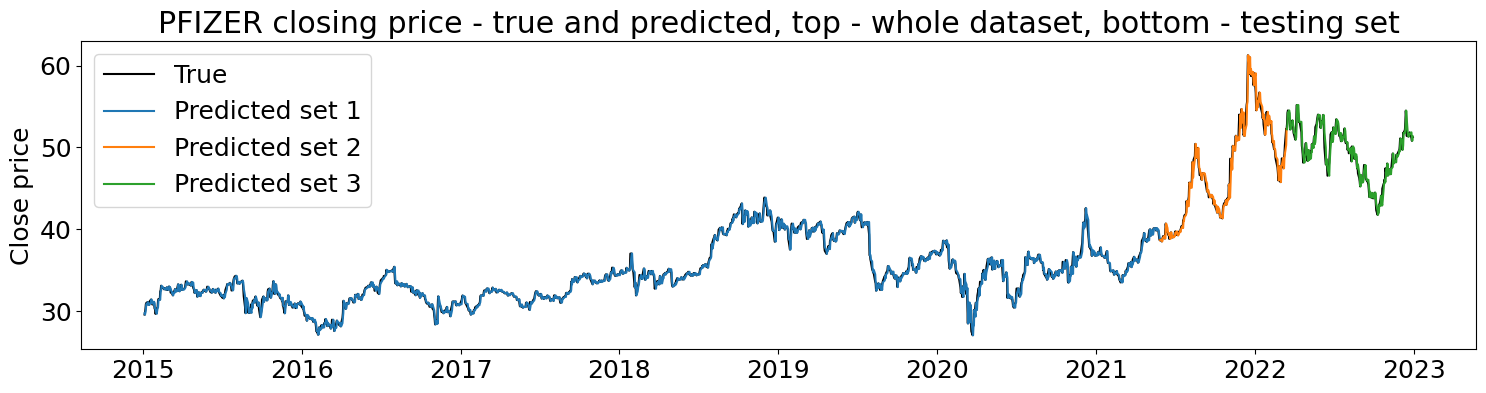

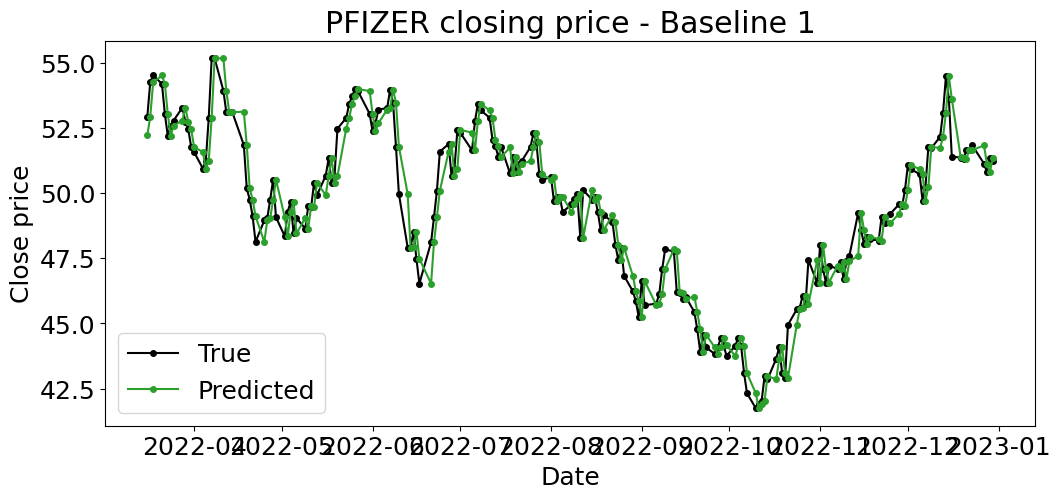

In [9]:
for tick, name in zip(stock_names, full_names):
  baseline_0(tick, name, test, val, to_add)

# Class

In [13]:
class StockFeatures:
  def __init__(self, data):
    # data: DataFrame
    self.data = data
    self.new_data = pd.DataFrame()
    self.columns = self.data.columns.values
    self.p_max = 0
    self.target_name = None
    self.X = None
    self.y = None
    self.dates = None

  def choose_columns(self, names):
    # names: list of strings
    for name in names:
      if name not in self.columns:
        raise ValueError(f"No '{name}' in the dataframe")
      else:
        self.new_data[name] = self.data[name]

  def choose_columns_diff(self, names):
    # names: list of strings
    for name in names:
      if name not in self.columns:
        raise ValueError(f"No '{name}' in the dataframe")
      else:
        self.new_data[f"{name}_diff"] = self.data[name].diff(1)
        self.new_data.dropna(inplace=True)

  def choose_columns_pct(self, names):
    # names: list of strings
    for name in names:
      if name not in self.columns:
        raise ValueError(f"No '{name}' in the dataframe")
      else:
        self.new_data[f"{name}_pct"] = self.data[name].pct_change()
        self.new_data.dropna(inplace=True)

  def add_MA(self, name, p):
    if name not in self.columns:
      raise ValueError(f"No '{name}' in the dataframe")
    else:
      self.new_data[f"MA_{name}_{p}"] = ta.ema(self.data[name], length=p)
      if p > self.p_max:
        self.p_max = p

  def add_RSI(self, name, p):
    if name not in self.columns:
      raise ValueError(f"No '{name}' in the dataframe")
    else:
      self.new_data[f"RSI_{name}_{p}"] = ta.rsi(self.data[name], length=p)
      if p > self.p_max:
        self.p_max = p

  def add_target_price(self, name):
    # Shifted price by one
    # name: column name to be shifted
    self.target_name = f"{name} target"
    if name not in self.columns:
      raise ValueError(f"No '{name}' in the dataframe")
    else:
      self.new_data[self.target_name] = self.data[name].shift(-1)
      self.new_data.dropna(inplace=True)

  def add_target_price_diff(self, name):
    self.target_name = f"{name} target diff"
    if name not in self.columns:
      raise ValueError(f"No '{name}' in the dataframe")
    else:
      self.new_data[self.target_name] = self.new_data[f"{name}_diff"].shift(-1)
      self.new_data.dropna(inplace=True)

  def add_target_price_pct(self, name):
    self.target_name = f"{name} target pct"
    if name not in self.columns:
      raise ValueError(f"No '{name}' in the dataframe")
    else:
      self.new_data[self.target_name] = self.new_data[f"{name}_pct"].shift(-1)
      self.new_data.dropna(inplace=True)

  def X_days_back(self, days):
    # Creates inputs.
    # days: int, number of days to be in one sample
    self.X = []
    data_np_X = np.array(self.new_data.drop(columns=self.target_name))
    data_np_y = np.array(self.new_data[self.target_name])
    for i in range(len(self.new_data.drop(columns=self.target_name).columns)):
      self.X.append([])
      for j in range(days, data_np_X.shape[0]+1):
        self.X[i].append(data_np_X[j-days:j, i])
    self.X = np.moveaxis(self.X, [0], [2])
    self.X = np.array(self.X)
    y_help = np.array(data_np_y[days-1:])
    self.y = np.reshape(y_help, (len(y_help),1))
    self.dates = self.new_data.index[-len(self.y):]

  def train_valid_test(self, test=0.1, val=0.1):
    # Splits data into train, valid and test sets
    for_test = int(len(self.data) * test)
    for_val = int(len(self.data) * val)
    to_train = len(self.X) - for_test - for_val
    self.X_train, self.X_val, self.X_test = self.X[:to_train], self.X[to_train:to_train+for_val], self.X[to_train+for_val:]
    self.y_train, self.y_val, self.y_test = self.y[:to_train], self.y[to_train:to_train+for_val], self.y[to_train+for_val:]
    self.dates_train, self.dates_val, self.dates_test = self.dates[:to_train], self.dates[to_train:to_train+for_val], self.dates[to_train+for_val:]

  def train_test(self, test=0.1):
    # Splits data into train, and test sets
    for_test = int(len(self.data) * test)
    to_train = len(self.X) - for_test
    self.X_train, self.X_test = self.X[:to_train], self.X[to_train:]
    self.y_train, self.y_test = self.y[:to_train], self.y[to_train:]
    self.dates_train, self.dates_test = self.dates[:to_train], self.dates[to_train:]

  def min_max_scale_X_val(self):
    sc = MinMaxScaler()
    self.X_train = sc.fit_transform(self.X_train.reshape(-1, self.X_train.shape[-1])).reshape(self.X_train.shape)
    self.X_val = sc.transform(self.X_val.reshape(-1, self.X_val.shape[-1])).reshape(self.X_val.shape)
    self.X_test = sc.transform(self.X_test.reshape(-1, self.X_test.shape[-1])).reshape(self.X_test.shape)

  def min_max_scale_X(self):
    scaler = MinMaxScaler()
    self.X_train = scaler.fit_transform(self.X_train.reshape(-1, self.X_train.shape[-1])).reshape(self.X_train.shape)
    self.X_test = scaler.transform(self.X_test.reshape(-1, self.X_test.shape[-1])).reshape(self.X_test.shape)

  def min_max_scale(self):
    self.scaler = MinMaxScaler()
    self.X_train = self.scaler.fit_transform(self.X_train.reshape(-1, self.X_train.shape[-1])).reshape(self.X_train.shape)
    self.X_test = self.scaler.transform(self.X_test.reshape(-1, self.X_test.shape[-1])).reshape(self.X_test.shape)
    self.y_train = self.scaler.transform(self.y_train)

# Linear Regression

In [10]:
k = 3
data = yf.download(tickers=stock_names[k], start='2015-01-01', end='2023-01-01')

[*********************100%%**********************]  1 of 1 completed


In [11]:
days_list = np.arange(1, 61)

In [14]:
mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []
mae_train_list = []
mae_test_list = []
mape_train_list = []
mape_test_list = []
for days in days_list:
  stock_obj = StockFeatures(data)
  stock_obj.choose_columns(['Close'])
  stock_obj.add_target_price('Close')
  stock_obj.X_days_back(days)
  stock_obj.train_valid_test(test=0.1)

  lr = LinearRegression()
  lr.fit(stock_obj.X_train.reshape(-1, days), stock_obj.y_train)
  y_train_pred_lr = lr.predict(stock_obj.X_train.reshape(-1, days))
  y_test_pred_lr = lr.predict(stock_obj.X_val.reshape(-1, days))

  y_train = stock_obj.y_train
  y_test = stock_obj.y_test

  mse_train_list.append(mean_squared_error(y_train, y_train_pred_lr))
  mse_test_list.append(mean_squared_error(y_test, y_test_pred_lr))
  r2_train_list.append(r2_score(y_train, y_train_pred_lr))
  r2_test_list.append(r2_score(y_test, y_test_pred_lr))
  mae_train_list.append(mean_absolute_error(y_train, y_train_pred_lr))
  mae_test_list.append(mean_absolute_error(y_test, y_test_pred_lr))
  mape_train_list.append(mean_absolute_percentage_error(y_train, y_train_pred_lr))
  mape_test_list.append(mean_absolute_percentage_error(y_test, y_test_pred_lr))

In [15]:
def plot_results_train_val_test(stock_obj, name, y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred):
  m1 = mean_squared_error(y_train, y_train_pred)
  m2 = mean_squared_error(y_val, y_val_pred)
  m3 = mean_squared_error(y_test, y_test_pred)
  print(f'MSE: {m1:.4f},  {m2:.4f},  {m3:.4f}')
  m1 = mean_absolute_percentage_error(y_train, y_train_pred)
  m2 = mean_absolute_percentage_error(y_val, y_val_pred)
  m3 = mean_absolute_percentage_error(y_test, y_test_pred)
  print(f'MAPE: {m1:.4f},  {m2:.4f},  {m3:.4f}')
  plt.figure(figsize=(12, 5))
  plt.plot(stock_obj.dates_test, y_test, '-o', color='k', label='True', markersize=4)
  plt.plot(stock_obj.dates_test, y_test_pred, '-o', color='tab:green', label='Predicted', markersize=4)
  plt.title(f'{name} closing price - Baseline 2')
  plt.xlabel('Date')
  plt.ylabel('Close price')
  plt.legend()
  plt.show()

In [16]:
df_comparison = pd.DataFrame({'days': days_list,
                              'MSE_train': mse_train_list,
                              'MSE_test': mse_test_list,
                              'R2_train': r2_train_list,
                              'R2_test': r2_test_list,
                              'MAE_train': mae_train_list,
                              'MAE_test': mae_test_list,
                              'MAPE_train': mape_train_list,
                              'MAPE_test': mape_test_list})
df_comparison

,days,MSE_train,MSE_test,R2_train,R2_test,MAE_train,MAE_test,MAPE_train,MAPE_test
0,1,0.217629,74.947589,0.981763,-6.672727,0.320395,7.574774,0.009339,0.154637
1,2,0.217368,74.935604,0.981774,-6.671500,0.320052,7.574610,0.009329,0.154635
2,3,0.217351,74.942016,0.981767,-6.672156,0.320323,7.575234,0.009338,0.154647
3,4,0.217311,74.955286,0.981765,-6.673515,0.320578,7.575666,0.009344,0.154656
4,5,0.217027,74.932738,0.981788,-6.671206,0.319949,7.574423,0.009323,0.154633
5,6,0.217149,74.938152,0.981778,-6.671761,0.320100,7.574561,0.009327,0.154636
6,7,0.217190,74.913668,0.981775,-6.669254,0.320042,7.572968,0.009325,0.154603
7,8,0.216237,75.001790,0.981854,-6.678275,0.320958,7.578165,0.009347,0.154709
8,9,0.214882,74.925667,0.981967,-6.670482,0.320979,7.572782,0.009346,0.154600
9,10,0.213663,75.016634,0.982067,-6.679795,0.320933,7.578456,0.009345,0.154713


In [17]:
best_rmse = np.argmin(mse_test_list) + 1
best_r2 = np.argmax(r2_test_list) + 1
best_mae = np.argmin(mae_test_list) + 1
best_mape = np.argmin(mape_test_list) + 1
print(f'best MSE for days: {best_rmse}')
print(f'best R2 for days: {best_r2}')
print(f'best MAE for days: {best_mae}')
print(f'best MAPE for days: {best_mape}')

best MSE for days: 30
best R2 for days: 30
best MAE for days: 9
best MAPE for days: 9


days: 30 coef: [[ 0.03456121 -0.03125939  0.0091858  -0.01093216  0.04241269 -0.02944845
   0.03511446 -0.03820075 -0.04244948  0.07384661 -0.05685551 -0.01740478
   0.04340766 -0.09034142  0.07915151  0.04245187 -0.02652439 -0.04372924
  -0.00195732  0.08634827 -0.12976947  0.14001293 -0.13183337  0.08284001
  -0.01852001  0.03045494 -0.04851892  0.00671138  0.03264059  0.97086999]] intercept: [0.27070706]
1582 201 201
MSE: 0.2088,  0.9627,  0.6665
MAPE: 0.0093,  0.0139,  0.0131


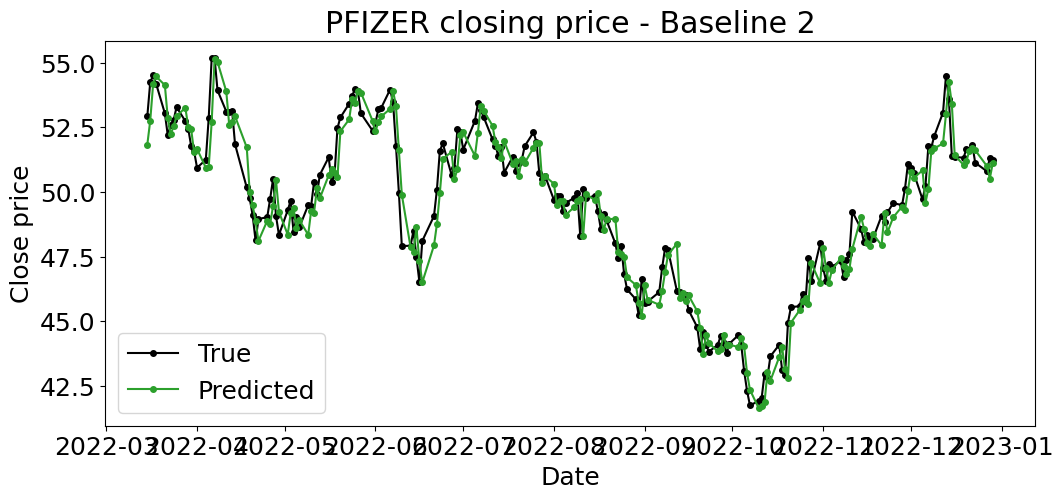

In [18]:
for days in [30]:
  stock_obj = StockFeatures(data)
  stock_obj.choose_columns(['Close'])
  stock_obj.add_target_price('Close')
  stock_obj.X_days_back(days)
  stock_obj.train_valid_test()
  #stock_obj.min_max_scale_X()
  lr = LinearRegression()
  lr.fit(stock_obj.X_train.reshape(-1, days), stock_obj.y_train)
  print(f'days: {days} coef: {lr.coef_} intercept: {lr.intercept_}')
  y_train_pred_lr = lr.predict(stock_obj.X_train.reshape(-1, days))
  y_val_pred_lr = lr.predict(stock_obj.X_val.reshape(-1, days))
  y_test_pred_lr = lr.predict(stock_obj.X_test.reshape(-1, days))

  y_train = stock_obj.y_train
  y_val = stock_obj.y_val
  y_test = stock_obj.y_test
  print(len(y_train), len(y_val), len(y_test))
  plot_results_train_val_test(stock_obj, full_names[k], y_train, y_train_pred_lr, y_val, y_val_pred_lr, y_test, y_test_pred_lr)